- 수치 예측에서는 마지막 레이어에 활성화 함수를 주지 않는다. 
- hidden layer에서는 여전히 활성화 함수가 필요하다.


patience 연속으로 바뀌지 않으면 조기정지

ModelCheckpoint('파일명',monitor='val_mse',mode='min',min_set_point=Ture)

언더 피팅 문제가 생길 수 있기에 사용에 주의하여야 한다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
tf.__version__

'2.5.0'

## Dataset Load

In [3]:
from tensorflow.keras.datasets import boston_housing

(train_data,train_targets),(X_test,y_test) = boston_housing.load_data()

In [4]:
print(train_data.shape)
print(X_test.shape)

print(train_targets[:10])
print(y_test[:10])

(404, 13)
(102, 13)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]
[ 7.2 18.8 19.  27.  22.2 24.5 31.2 22.9 20.5 23.2]


## Preprocessing

In [5]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data = train_data-mean
train_data = train_data/std

In [6]:
X_test = X_test-mean
X_test = X_test / std

In [7]:
from sklearn.model_selection import train_test_split

X_train,X_valid,y_train,y_valid = train_test_split(train_data,train_targets,test_size=0.2,random_state=2045)

X_train.shape,X_valid.shape,y_train.shape,y_valid.shape

((323, 13), (81, 13), (323,), (81,))

## keras modeling

In [8]:
from tensorflow.keras import models
from tensorflow.keras import layers

boston = models.Sequential(name='Regression')
boston.add(layers.Dense(64,activation='relu',input_shape=(13,)))
boston.add(layers.Dense(64,activation='relu'))
boston.add(layers.Dense(1))

In [9]:
boston.summary()

Model: "Regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [10]:
# compile

boston.compile(loss='mse',optimizer='rmsprop',metrics=['mae'])

In [11]:
%%time
Hist_boston = boston.fit(X_train,y_train,epochs=500,
                         batch_size=1,
                         validation_data=(X_valid,y_valid))

Epoch 1/500
323/323 [==============================] - 1s 2ms/step - loss: 212.0100 - mae: 10.9237 - val_loss: 56.1168 - val_mae: 4.4213
Epoch 2/500
323/323 [==============================] - 0s 1ms/step - loss: 31.6011 - mae: 3.9937 - val_loss: 35.9837 - val_mae: 3.3494
Epoch 3/500
323/323 [==============================] - 0s 1ms/step - loss: 21.9064 - mae: 3.1864 - val_loss: 25.0632 - val_mae: 2.8891
Epoch 4/500
323/323 [==============================] - 0s 1ms/step - loss: 17.8525 - mae: 2.8239 - val_loss: 23.4786 - val_mae: 2.6546
Epoch 5/500
323/323 [==============================] - 0s 1ms/step - loss: 15.4088 - mae: 2.5953 - val_loss: 20.7734 - val_mae: 2.6984
Epoch 6/500
323/323 [==============================] - 0s 1ms/step - loss: 13.8537 - mae: 2.4679 - val_loss: 18.0288 - val_mae: 2.6342
Epoch 7/500
323/323 [==============================] - 0s 1ms/step - loss: 12.9959 - mae: 2.3720 - val_loss: 18.3799 - val_mae: 2.5244
Epoch 8/500
323/323 [==============================] 

In [12]:
test_mse_score,test_mae_score = boston.evaluate(X_test,y_test)

print('MSE: ',test_mse_score)
print('MAE: ',test_mae_score)

4/4 [==============================] - 0s 3ms/step - loss: 20.8956 - mae: 3.1081
MSE:  20.895605087280273
MAE:  3.1081366539001465


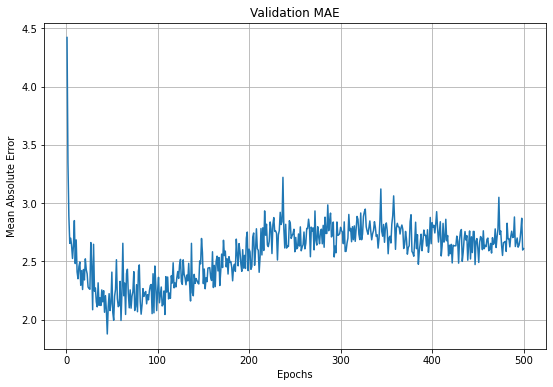

In [15]:
import matplotlib.pyplot as plt
epochs = range(1,len(Hist_boston.history['val_mae'])+1)

plt.figure(figsize=(9,6))
plt.plot(epochs,Hist_boston.history['val_mae'])
plt.title('Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.grid()
plt.show()

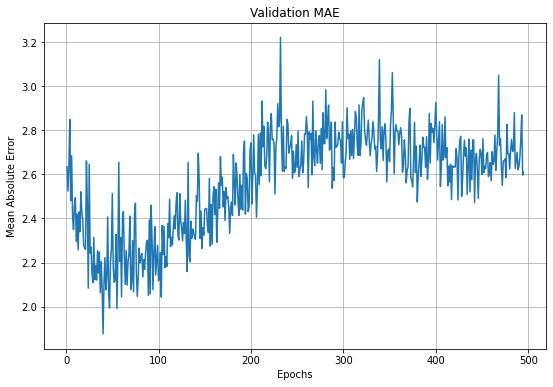

In [16]:
mae_history=Hist_boston.history['val_mae']
mae_history=mae_history[5:]


plt.figure(figsize=(9,6))
plt.plot(range(1,len(mae_history)+1),mae_history)
plt.title('Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.grid()
plt.show()

In [17]:
# keras session clear
from tensorflow.keras import backend as K
K.clear_session()

## Early Stopping 

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

es=EarlyStopping(monitor='val_mae', mode='min', patience=50,verbose=1)

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint('best_boston.h5',monitor='val_mae',mode='min',save_best_only=True,verbose=1)

In [20]:
Hist_boston = boston.fit(X_train,y_train,
                         epochs=500,
                         batch_size=1,
                         validation_data=(X_valid,y_valid),
                         callbacks=[es,mc],
                         verbose=1)

Epoch 1/500
323/323 [==============================] - 1s 2ms/step - loss: 0.8757 - mae: 0.6905 - val_loss: 15.9634 - val_mae: 2.5784

Epoch 00001: val_mae improved from inf to 2.57844, saving model to best_boston.h5
Epoch 2/500
323/323 [==============================] - 0s 1ms/step - loss: 0.7772 - mae: 0.6779 - val_loss: 18.6074 - val_mae: 2.7617

Epoch 00002: val_mae did not improve from 2.57844
Epoch 3/500
323/323 [==============================] - 0s 1ms/step - loss: 0.7405 - mae: 0.6660 - val_loss: 19.7199 - val_mae: 2.8111

Epoch 00003: val_mae did not improve from 2.57844
Epoch 4/500
323/323 [==============================] - 0s 1ms/step - loss: 0.8200 - mae: 0.6953 - val_loss: 17.7665 - val_mae: 2.8674

Epoch 00004: val_mae did not improve from 2.57844
Epoch 5/500
323/323 [==============================] - 0s 1ms/step - loss: 0.7856 - mae: 0.6753 - val_loss: 17.6918 - val_mae: 2.7095

Epoch 00005: val_mae did not improve from 2.57844
Epoch 6/500
323/323 [======================

In [21]:
!ls -l

total 76
-rw-r--r-- 1 root root 70280 Aug  5 08:58 best_boston.h5
drwxr-xr-x 1 root root  4096 Jul 16 13:20 sample_data


In [24]:
test_mse_score,test_mae_score =boston.evaluate(X_test,y_test)

print('MAE: ',test_mae_score)

4/4 [==============================] - 0s 3ms/step - loss: 17.7086 - mae: 2.7560
MAE:  2.7560250759124756
